**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense

In [2]:
# Reading data from csv
train = pd.read_csv("fake-news/train.csv")
test  = pd.read_csv("fake-news/test.csv")
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


**Checking Null Values**

In [5]:
# Checking the null values in training data.
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Checking the null values in testing data.
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [7]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [8]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+ train["author"]
test["merged"]  = test["title"]+" "+ test["author"]

In [9]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [10]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [11]:
messages["text"][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [12]:
messages.head()

,index,id,title,author,text,merged
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [13]:
messages_test.head()

,index,id,title,author,text,merged
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [14]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [15]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [16]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [17]:
one_hot_test[1]

[4518, 1052, 2195, 4414, 2598, 978, 3256]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [18]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 3501  542  898]
 [   0    0    0 ... 1857 1422 1512]
 [   0    0    0 ... 3787 4199 1154]
 ...
 [   0    0    0 ... 3216 2373 2331]
 [   0    0    0 ... 1795 1793 1945]
 [   0    0    0 ... 3981 4468 4131]]


In [19]:
embedd_docs_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0, 4261, 2317, 3696,
       1554, 1653, 3140, 2596, 2151, 4043, 3501,  542,  898])

In [20]:
print(embedd_docs_test)

[[   0    0    0 ... 3919 4468 3967]
 [   0    0    0 ... 2598  978 3256]
 [   0    0    0 ... 4734 4851  596]
 ...
 [   0    0    0 ... 3919 3886 2904]
 [   0    0    0 ... 4518 4515 3796]
 [   0    0    0 ... 3919 3187  949]]


In [21]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [22]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

## Baseline Models

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [25]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": MultinomialNB(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "XGBoost Classifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier(iterations=150)}

# Create a function to fit and score models
def fit_and_score(models, X_train, x_test, Y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn Machine Learning models
    X_train: Training data (no labels)
    X_test: Testing data (no labels)
    y_train: Training labels
    y_test: Test labels
    """
    
    # Set random seed
    np.random.seed(12)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, Y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
        
    return model_scores

In [26]:
model_scores = fit_and_score(models=models, X_train=X_train, x_test=x_test, Y_train=Y_train, y_test=y_test)
model_scores

C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.195972
0:	learn: 0.5581795	total: 178ms	remaining: 26.6s
1:	learn: 0.4870047	total: 191ms	remaining: 14.1s
2:	learn: 0.4259445	total: 203ms	remaining: 9.92s
3:	learn: 0.4006294	total: 212ms	remaining: 7.74s
4:	learn: 0.3761002	total: 223ms	remaining: 6.46s
5:	learn: 0.3555799	total: 234ms	remaining: 5.62s
6:	learn: 0.3422021	total: 246ms	remaining: 5.03s
7:	learn: 0.3325227	total: 258ms	remaining: 4.58s
8:	learn: 0.3241758	total: 270ms	remaining: 4.23s
9:	learn: 0.3095919	total: 280ms	remaining: 3.92s
10:	learn: 0.3028136	total: 292ms	remaining: 3.69s
11:	learn: 0.2931129	total: 307ms	remaining: 3.53s
12:	learn: 0.2862085	total: 323ms	remaining: 3.41s
13:	learn: 0.2813794	total: 337ms	remaining: 3.27s
14:	learn: 0.2735053	total: 349ms	remaining: 3.14s
15:	learn: 0.2698570	total: 363ms	remaining: 3.04s
16:	learn: 0.2669111	total: 383ms	remaining: 3s
17:	learn: 0.2629596	total: 399ms	remaining: 2.92s
18:	learn: 0.2608315	total: 413ms	remaining: 2.85s
19:	learn: 0.2

{'Logistic Regression': 0.698076923076923,
 'KNN': 0.7668269230769231,
 'Random Forest': 0.9024038461538462,
 'Naive Bayes': 0.6538461538461539,
 'Decision Tree Classifier': 0.9158653846153846,
 'XGBoost Classifier': 0.916826923076923,
 'CatBoost Classifier': 0.9754807692307692}

**1. Logistic Regresssion**

In [27]:
# model_1 = LogisticRegression(max_iter=150)
# model_1.fit(X_train,Y_train)
# pred_1 = model_1.predict(x_test)
# cr1    = classification_report(y_test,pred_1)
# print(cr1)

**2. Naive Bayes**

In [28]:
# model_2 = MultinomialNB()
# model_2.fit(X_train,Y_train)
# pred_2 = model_2.predict(x_test)
# cr2    = classification_report(y_test,pred_2)
# print(cr2)

**3. Decision Trees**

In [29]:
# model_3 = DecisionTreeClassifier()
# model_3.fit(X_train,Y_train)
# pred_3 = model_3.predict(x_test)
# cr3    = classification_report(y_test,pred_3)
# print(cr3)

**4. Random Forest**

In [30]:
# model_4 = RandomForestClassifier()
# model_4.fit(X_train,Y_train)
# pred_4 = model_4.predict(x_test)
# cr4    = classification_report(y_test,pred_4)
# print(cr4)

**5. XGBOOST**

In [31]:
# model_5 = XGBClassifier()
# model_5.fit(X_train,Y_train)
# pred_5 = model_5.predict(x_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)

**6.Catboost**

In [32]:
# model_6 = CatBoostClassifier(iterations=150)
# model_6.fit(X_train,Y_train)
# pred_6 = model_5.predict(x_test)
# cr6    = classification_report(y_test,pred_5)
# print(cr6)

**7. LSTM**

**In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.**

In [33]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
264/264 [==============================] - 6s 17ms/step - loss: 0.3848 - accuracy: 0.8133 - val_loss: 0.0506 - val_accuracy: 0.9813
Epoch 2/10
264/264 [==============================] - 4s 14ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0289 - val_accuracy: 0.9915
Epoch 3/10
264/264 [==============================] - 4s 14ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0227 - val_accuracy: 0.9920
Epoch 4/10
264/264 [==============================] - 4s 15ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0291 - val_accuracy: 0.9915
Epoch 5/10
264/264 [==============================] - 4s 15ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.0251 - val_accuracy: 0.9920
Epoch 6/10
264/264 [==============================] - 4s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9909
Epoch 7/10
264/264 [==============================] - 4s 14ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0276 - val_accuracy: 0.9909

In [35]:
predictions = model.predict_classes(x_test)
score_lstm = accuracy_score(y_test,predictions)
score_lstm

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9884615384615385

In [36]:
# predictions = model.predict_classes(x_test)
# cr = classification_report(y_test,predictions)
# print(cr)

In [37]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest,Naive Bayes,Decision Tree Classifier,XGBoost Classifier,CatBoost Classifier
Accuracy,0.698077,0.766827,0.902404,0.653846,0.915865,0.916827,0.975481


In [38]:
model_compare["LSTM"] = score_lstm

In [39]:
model_compare

,Logistic Regression,KNN,Random Forest,Naive Bayes,Decision Tree Classifier,XGBoost Classifier,CatBoost Classifier,LSTM
Accuracy,0.698077,0.766827,0.902404,0.653846,0.915865,0.916827,0.975481,0.988462


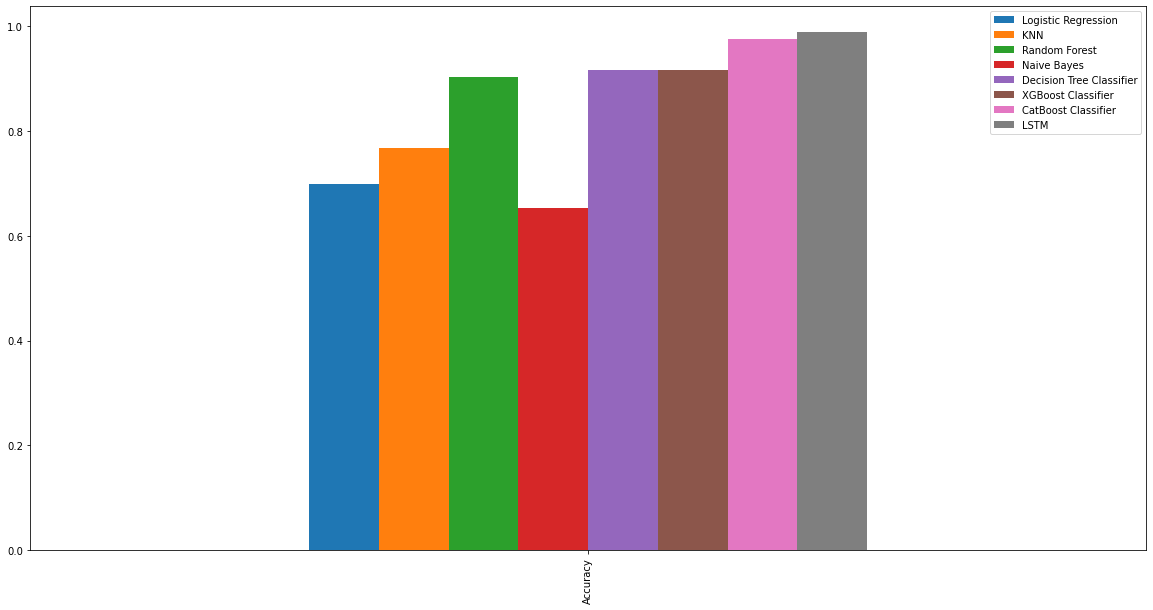

In [40]:
model_compare.plot(kind="bar", figsize=(20, 10));

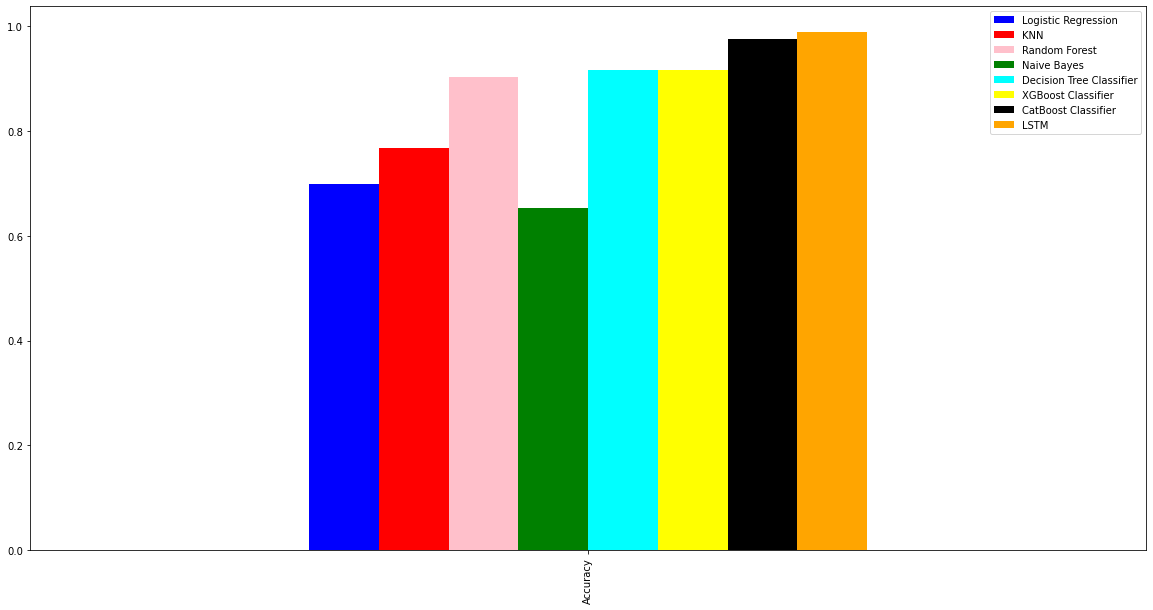

In [41]:
model_compare.plot(kind="bar", color=['blue', 'red','pink','green', 'cyan', 'yellow', 'black','orange'], figsize=(20, 10));

# Confusion Matrix for All Models

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True Label")
    plt.ylabel(f'Predicted Label using {model}')
    
plot_conf_mat(y_test, y_preds)

# Evaluation of Models

**Tabulating the results of various implemented models.**

In [ ]:
# score_1 = accuracy_score(y_test,pred_1)
# score_2 = accuracy_score(y_test,pred_2)
# score_3 = accuracy_score(y_test,pred_3)
# score_4 = accuracy_score(y_test,pred_4)
# score_5 = accuracy_score(y_test,pred_5)
# score_6 = accuracy_score(y_test,pred_6)
# score_7 = accuracy_score(y_test,predictions)
# results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
#                        ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],["LSTM",score_7]],columns=["Model","Accuracy"])
# results

**Discussion: From the above results, it appears that LSTM Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.**

## RandomizedSearch CV

### Only trying this on RF, CatBoost, XGBoost and Decision Trees

In [ ]:
# Create a hyperparameter grid for RandomForestClassifier
rfc_grid = {"n_estimators": np.arange(0, 1000, 100),
           "max_depth": [None, 1, 2, 3, 5],
           "min_samples_split": np.arange(0, 10, 2),
           "min_samples_leaf": np.arange(0, 10, 1)}

# Create a hyperparameter grid for DecisionTreesClassifier
dtc_grid = {"max_depth": np.arange(0, 100, 1),
           "min_samples_split": np.arange(0, 100, 1),
           "min_samples_leaf": np.arange(0, 100, 1),
           "max_leaf_nodes": np.arange(0, 100, 1)}

# Create a hyperparameter grid for XGBoostClassifier
xgb_grid = {"max_depth" : np.arange(0, 10, 1),
            "learning_rate" : [0, 0.01, 0.05, 0.1, 0.15, 0.2],
            "n_estimators" : np.arange(0, 1000, 50),
            "verbosity" : [0, 1]}

# Create a hyperparameter grid for CatBoostClassifier
catb_grid = {'depth'         : [4,5,6,7,8,9,10],
             'learning_rate' : [0.01,0.02,0.03,0.04],
             'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

In [ ]:
# Tune RFC
np.random.seed(12)

# Setup random hyperparameeter search for RFC
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rfc_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for RFC
rs_rfc.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_rfc.best_params_

In [ ]:
# Best score
rs_rfc.score(x_test, y_test)

In [ ]:
# Setup random seed
np.random.seed(24)

# Setup random hyperparameter search for DecisionTreeClassifier
rs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dtc_grid,
                           cv=5,
                           n_iter=300,
                           verbose=True)

# Fit the random hyperparameter search model for DecisionTreeClassifier()
rs_dtc.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_dtc.best_params_

In [ ]:
# Best score
rs_dtc.score(x_test, y_test)

In [ ]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=30,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_xgb.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_xgb.best_params_

In [ ]:
# Best score
rs_xgb.score(x_test, y_test)

In [ ]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_cbc = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=40,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_cbc.fit(X_train, Y_train)

In [ ]:
# Find the best hyperparameters
rs_cbc.best_params_

In [ ]:
# Best score
rs_cbc.score(x_test, y_test)

# GridSearchCV

In [ ]:
# Different hyperparameters for our RandomForest model
rfc_grid = {"n_estimators": np.arange(0, 200, 50),
           "max_depth": [None, 1],
           "min_samples_split": np.arange(6, 8, 1),
           "min_samples_leaf": np.arange(0, 2, 1)}

# Setup grid hyperparameter search for LogisticRegression
gs_rfc = GridSearchCV(RandomForestClassifier(),
                      param_grid=rfc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_rfc.fit(X_train, Y_train)

In [ ]:
# Check the best hyperparameters
gs_rfc.best_params_

In [ ]:
# Evaluate the grid search LogisticRegression model
gs_rfc.score(x_test, y_test)

In [ ]:
# Different hyperparameters for our RandomForest model
dtc_grid =  {'min_samples_split': [4, 5, 6, 7],
             'min_samples_leaf': [1, 2, 3],
             'max_leaf_nodes': np.arange(95, 100, 1),
             'max_depth': np.arange(75, 80, 1)}

# Setup grid hyperparameter search for LogisticRegression
gs_dtc = GridSearchCV(DecisionTreeClassifier(),
                      param_grid=dtc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_dtc.fit(X_train, Y_train)

In [ ]:
# Check the best hyperparameters
gs_dtc.best_params_

In [ ]:
# Evaluate the grid search LogisticRegression model
gs_dtc.score(x_test, y_test)

In [ ]:
# Make predictions with tuned model
y_preds = rs_rfc.predict(x_test)

In [ ]:
y_preds

In [ ]:
len(y_preds)

In [ ]:
len(x_test)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label using RFC")
    
plot_conf_mat(y_test, y_preds)

In [ ]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_rfc, x_test, y_test)